# Preprocessing

In [4]:
import glob
import os
import subprocess

data_path = '/mnt/d/Data/Chick/Imprinting/analysis/'

sub_dirs = glob.glob('%s/sub*'%(data_path))

###############################
TR = 4 #repitetion time per second

###############################
MotionCorrection = True

###############################  
SliceTimeCorrection = True
if SliceTimeCorrection:
    acquisitionType = 'odd'

###############################
Despiking = False

###############################
SpatialSmoothing = True
smooth = 8 #mm; 0 mean no spatial smoothing

###############################
TemporalFiltering = True
if TemporalFiltering:
    paradigm_hp = 200 #120second

###############################
for curr_sub in sub_dirs:
    print(curr_sub)
    #curr_bold = os.path.join(curr_sub,'results')
    #reg dir
    reg_dir = os.path.join(curr_sub,'reg')
    print(reg_dir)
    res_dir = os.path.join(curr_sub,'results/func_data_mc_st_ss8_tf200')# mc: motion correction; st: slice time correction; ss: spatial smoothing; tf: temporal filtering
    print(res_dir)
    os.makedirs(res_dir)
    
    os.system('fslmaths %s/results/bold %s/prefiltered_func_data -odt float'%(curr_sub, res_dir))
    
    # change directory to the res_dir 
    os.chdir(res_dir)
    
    #motion correction
    if MotionCorrection:
        print('motion correction is running ...')
        os.system("mcflirt -in prefiltered_func_data -out prefiltered_func_data_mcf -mats -plots -reffile %s/example_func -rmsrel -rmsabs -spline_final"%(reg_dir))
        os.system("mkdir -p mc ; mv -f prefiltered_func_data_mcf.mat prefiltered_func_data_mcf.par prefiltered_func_data_mcf_abs.rms prefiltered_func_data_mcf_abs_mean.rms prefiltered_func_data_mcf_rel.rms prefiltered_func_data_mcf_rel_mean.rms mc")
        os.system("fsl_tsplot -i %s/prefiltered_func_data_mcf.par -t 'MCFLIRT estimated rotations (radians)' -u 1 --start=1 --finish=3 -a x,y,z -w 640 -h 144 -o %s/rot.png"%('mc','mc'))
        os.system("fsl_tsplot -i %s/prefiltered_func_data_mcf.par -t 'MCFLIRT estimated translations (mm)' -u 1 --start=4 --finish=6 -a x,y,z -w 640 -h 144 -o %s/trans.png"%('mc','mc'))
        os.system("fsl_tsplot -i %s/prefiltered_func_data_mcf_abs.rms,prefiltered_func_data_mcf_rel.rms -t 'MCFLIRT estimated mean displacement (mm)' -u 1 -w 640 -h 144 -a absolute,relative -o %s/disp.png"%('mc','mc')) 
    else:
        print('no motion correction')
        os.system("fslmaths prefiltered_func_data prefiltered_func_data_mcf -odt float")         
    
    #slice time correction
    if SliceTimeCorrection:
        print('slice time correction is running ...')
        os.system("slicetimer -i prefiltered_func_data_mcf --out=prefiltered_func_data_st -r %s --%s"%(TR,acquisitionType))
        os.system("fslmaths prefiltered_func_data_st -Tmean mean_func")
    else:
        print('no slice time correction')
        os.system("fslmaths prefiltered_func_data_mcf prefiltered_func_data_st -odt float")
        os.system("fslmaths prefiltered_func_data_st -Tmean mean_func")
    
    #despiking
    if Despiking:
        print('despking is running ...')
        os.system("3dDespike -prefix prefiltered_func_data_despike.nii.gz prefiltered_func_data_st.nii.gz")
    else:
        print('no despiking')
        os.system("fslmaths prefiltered_func_data_st prefiltered_func_data_despike -odt float")
    
    # brain extraction         
    #os.system("bet2 mean_func mask -f 0.3 -n -m; immv mask_mask mask")
    
    # apply brain mask 
    os.system("fslmaths prefiltered_func_data_despike -mas %s/example_func_mask prefiltered_func_data_bet"%(reg_dir))
    
    #spatial smootiong
   
    print('spatial smooting is running ...')
    output = subprocess.check_output("fslstats prefiltered_func_data_bet -p 2 -p 98", shell=True).decode('utf-8')
    output_split = output.split()
    int2 = float(output_split[0])
    int98 = float(output_split[1])
    print(int2,int98)#0.000000 954.826904
    brain_thresh =10
    intensity_threshold = int2 + ( brain_thresh * ( int98 - int2 ) / 100.0)
    os.system("fslmaths prefiltered_func_data_bet -thr %s -Tmin -bin mask -odt char"%(intensity_threshold))
    median_intensity = subprocess.check_output("fslstats prefiltered_func_data_bet -k mask -p 50", shell=True).decode('utf-8')
    median_intensity = float(median_intensity)
    print(median_intensity)#705.560059 
    #os.system("fslmaths mask -dilF mask")
    os.system("fslmaths prefiltered_func_data_bet -mas mask prefiltered_func_data_thresh")
    os.system("fslmaths prefiltered_func_data_thresh -Tmean mean_func")
    susan_int = (median_intensity - int2) * 0.75
    smoothsigma = smooth / 2.355 
    os.system("susan prefiltered_func_data_thresh %s %s 3 1 1 mean_func %s prefiltered_func_data_smooth"%(susan_int,smoothsigma,susan_int))

    #Normalization
    normmean = 10000
    scaling = normmean / median_intensity
    os.system("fslmaths prefiltered_func_data_smooth -mas mask prefiltered_func_data_smooth")
    os.system("fslmaths prefiltered_func_data_smooth -mul %s prefiltered_func_data_intnorm"%(scaling))
    
    # temporal filtering
    if TemporalFiltering:
        print('temporal filtering is running ...')
        #highpass temporal filtering (Gaussian-weighted least-squares straight line fitting, with sigma=hp_sigma_sec)
        os.system("fslmaths prefiltered_func_data_intnorm -Tmean tempMean")
        hp_sigma_sec = paradigm_hp / 2.0 
        hp_sigma_vol = hp_sigma_sec / TR
        lp_sigma_vol = -1
        
        # if you want to do lowpass filtering, you cn using these lines:
        #Gaussian lowpass temporal filtering, with sigma=lp_sigma_sec
        #lp_sigma_sec = 2.8
        #lp_sigma_vol = lp_sigma_sec / TR
        os.system("fslmaths prefiltered_func_data_intnorm -bptf %s %s -add tempMean prefiltered_func_data_tempfilt"%(hp_sigma_vol, lp_sigma_vol))
        os.system("imrm tempMean")
        os.system("fslmaths prefiltered_func_data_tempfilt filtered_func_data")
    else:
        print('no temporal filtering')
        os.system("fslmaths prefiltered_func_data_intnorm filtered_func_data -odt float")
                  

    os.system("fslmaths filtered_func_data -Tmean mean_func")
    os.system("rm -rf prefiltered_func_data*")
   

/mnt/d/Data/Chick/Imprinting/analysis/sub09
/mnt/d/Data/Chick/Imprinting/analysis/sub09/reg
/mnt/d/Data/Chick/Imprinting/analysis/sub09/results/func_data_mc_st_ss8_tf200
motion correction is running ...
slice time correction is running ...
no despiking
spatial smooting is running ...
0.0 155.277603
118.272667
temporal filtering is running ...
/mnt/d/Data/Chick/Imprinting/analysis/sub11
/mnt/d/Data/Chick/Imprinting/analysis/sub11/reg
/mnt/d/Data/Chick/Imprinting/analysis/sub11/results/func_data_mc_st_ss8_tf200
motion correction is running ...
slice time correction is running ...
no despiking
spatial smooting is running ...
0.0 236.435699
181.195847
temporal filtering is running ...
/mnt/d/Data/Chick/Imprinting/analysis/sub12
/mnt/d/Data/Chick/Imprinting/analysis/sub12/reg
/mnt/d/Data/Chick/Imprinting/analysis/sub12/results/func_data_mc_st_ss8_tf200
motion correction is running ...
slice time correction is running ...
no despiking
spatial smooting is running ...
0.0 161.359711
126.2118
t

0.0 281.76889
204.952164
temporal filtering is running ...


# Plot Estimated Motion Parameters

Populating the interactive namespace from numpy and matplotlib
results


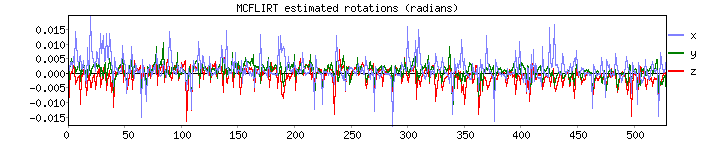

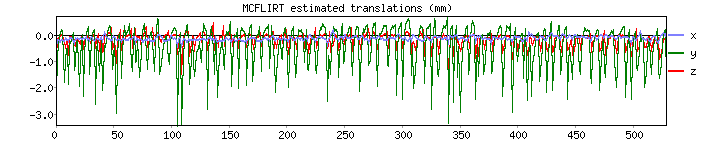

results


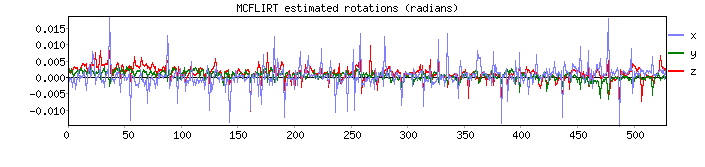

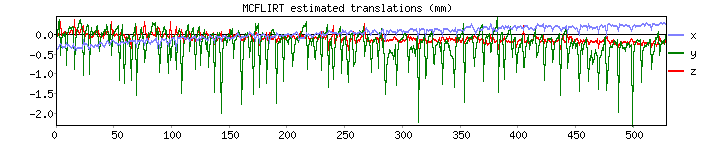

results


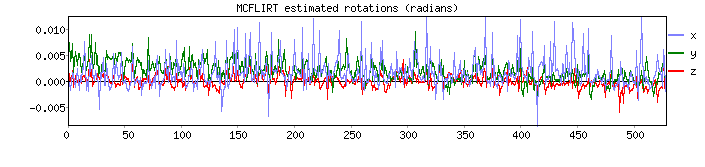

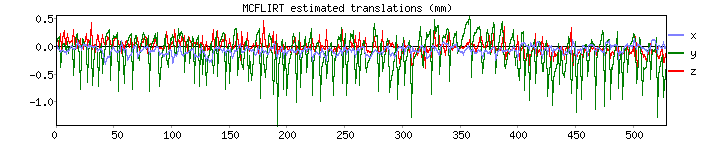

results


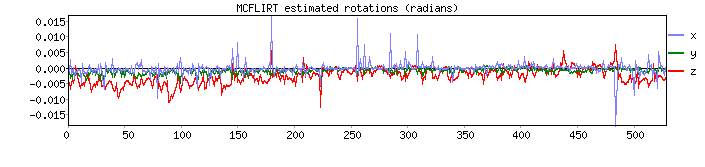

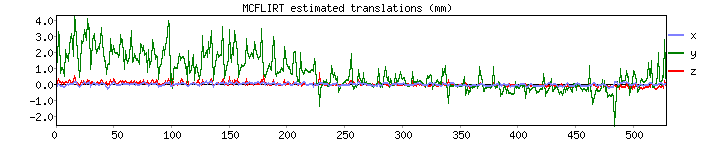

results


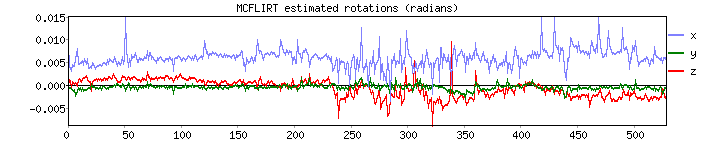

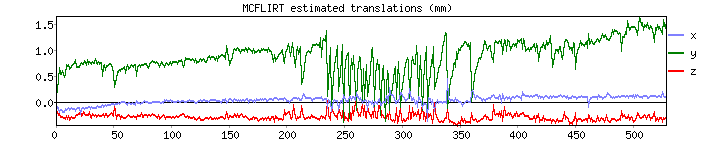

results


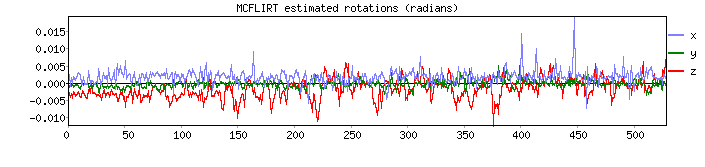

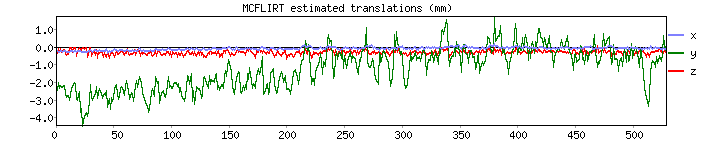

results


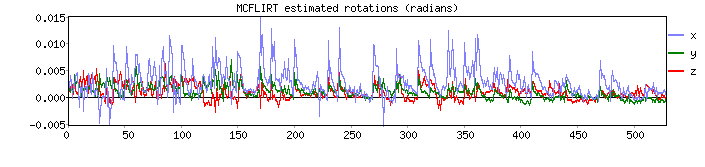

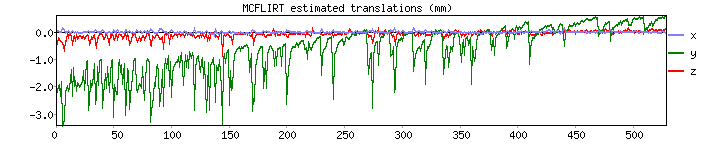

results


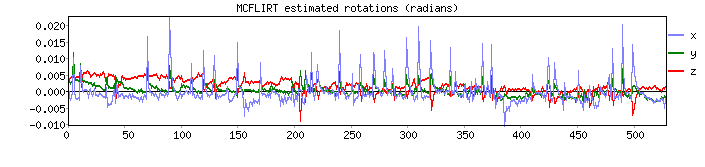

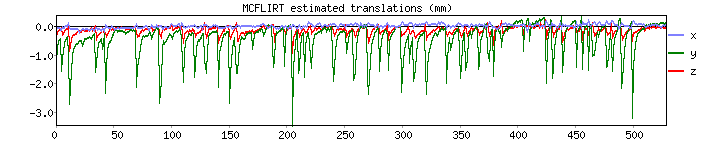

results


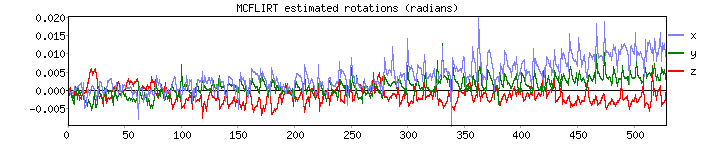

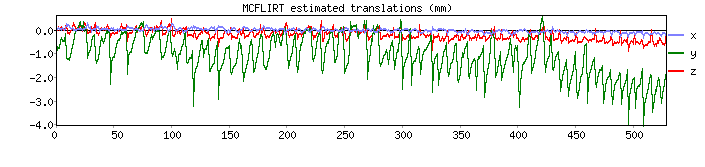

results


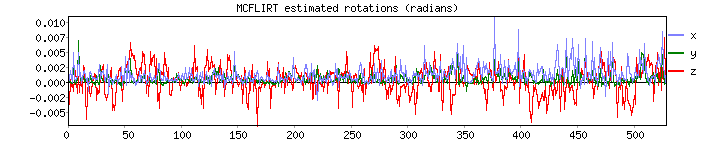

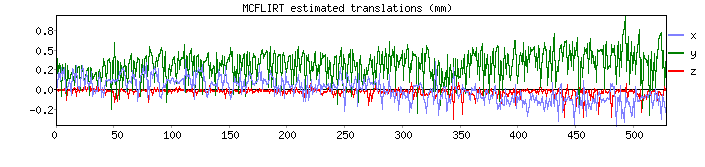

results


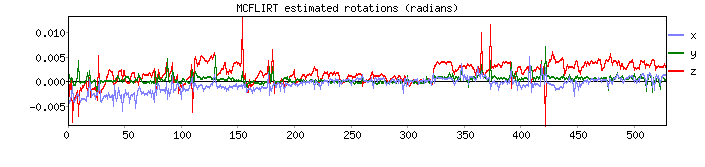

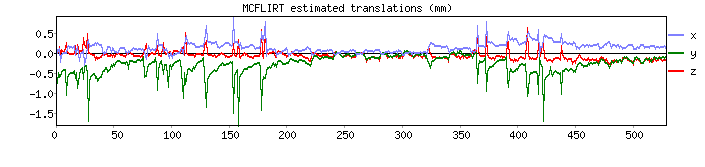

results


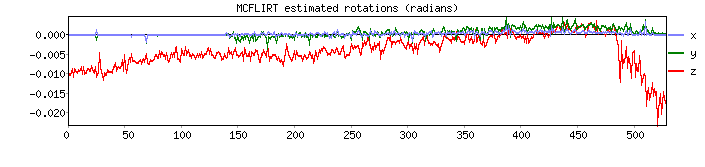

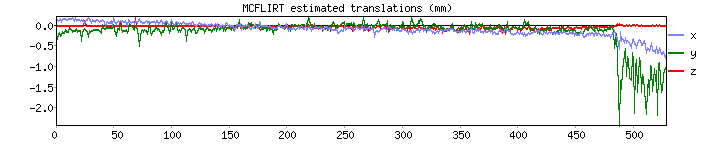

results


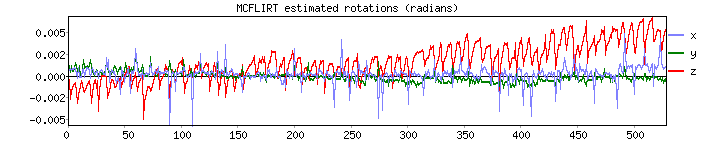

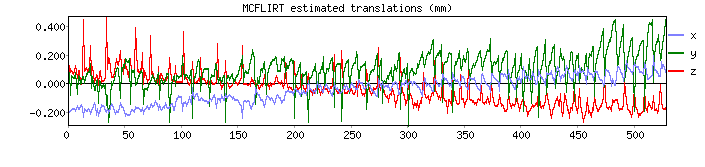

results


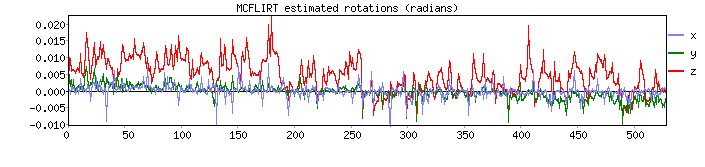

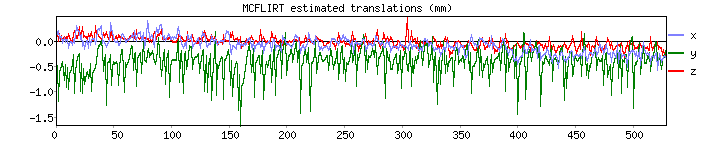

results


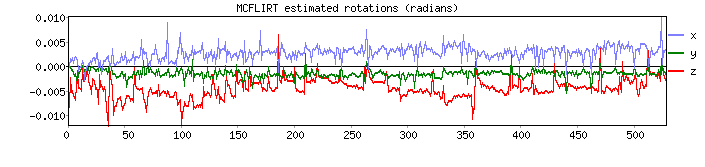

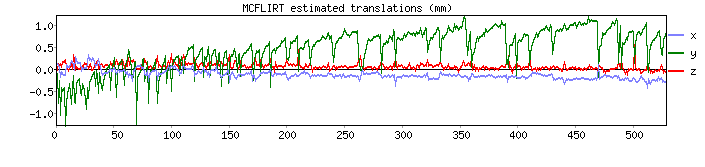

results


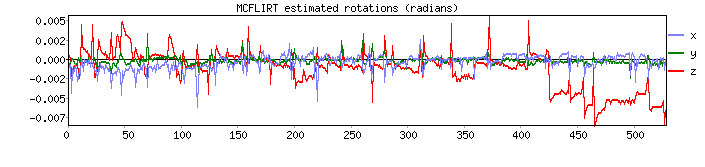

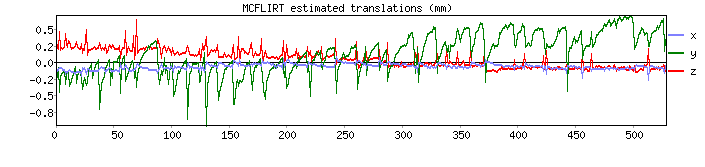

results


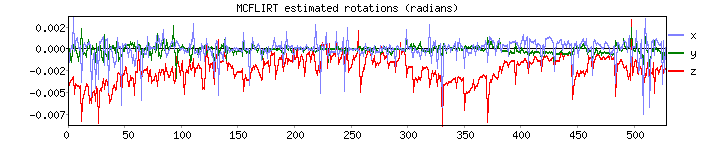

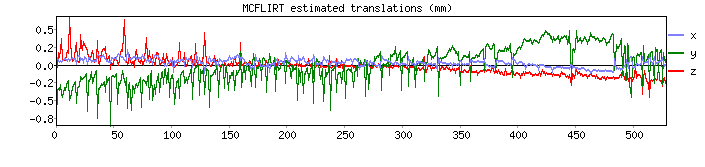

results


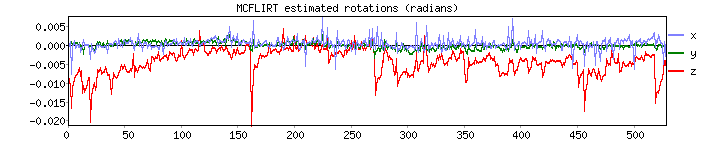

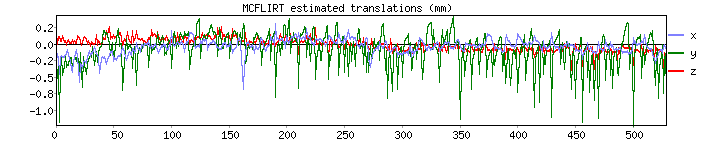

results


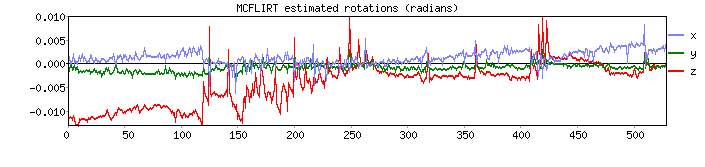

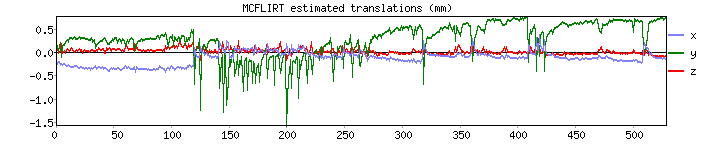

results


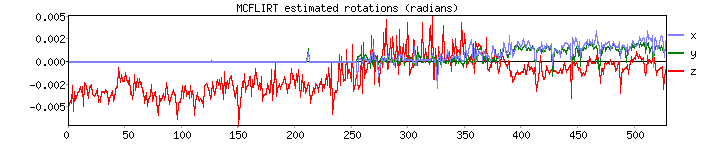

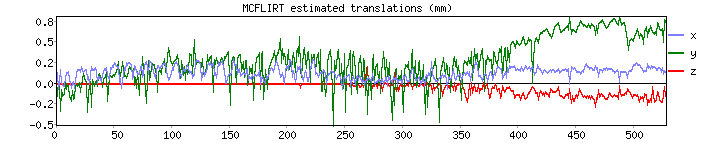

results


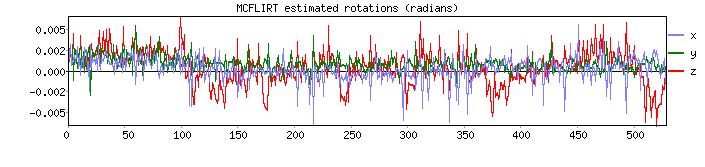

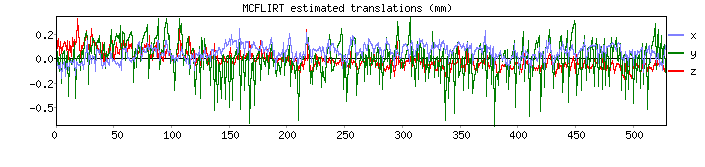

results


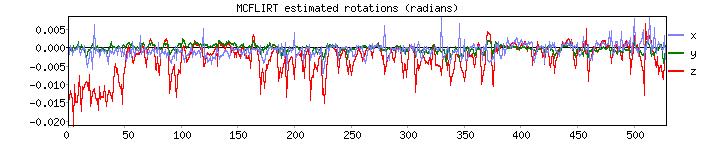

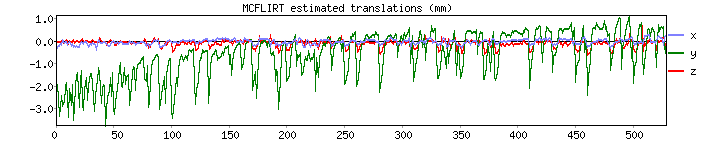

results


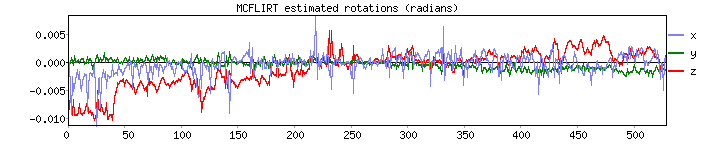

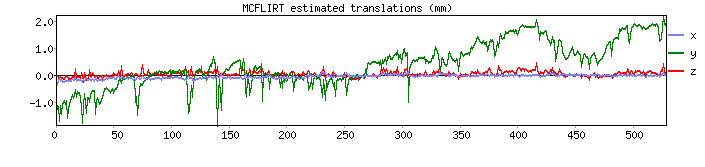

results


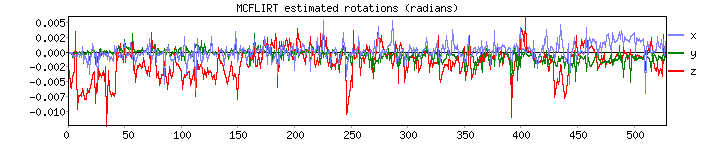

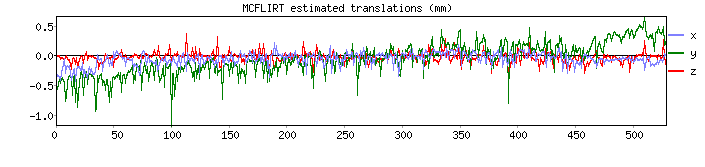

In [3]:
%matplotlib inline
%pylab inline

from IPython.display import display, Image
import glob
import os

data_path = '/mnt/d/Data/Chick/Imprinting/analysis'
func_dir = glob.glob('%s/sub*/results/func_data_mc_st_ss8_tf100*'%(data_path))

for curr_func in func_dir:
    
    mc_dir = curr_func+'/mc/'
    #print(reg_dir)
    #img = mpimg.imread(os.path.join(reg_dir, 'example_func2standard.png' ))
    print(curr_func.split('/')[-2])
    #imgplot = plt.imshow(img)
    plt.show()
    display(Image(filename=os.path.join(mc_dir, 'rot.png' )))
    display(Image(filename=os.path.join(mc_dir, 'trans.png' )))